In [5]:
import sys
from os import getcwd
from os.path import join
import pandas as pd
sys.path.insert(0, join(getcwd(), "../module_code"))

from data.load import load_data, load_outcomes
from data.utils import read_files_and_combine
from cli_utils import load_cli_args, init_cli_args

sys.argv = [sys.argv[0]]
load_cli_args("../options.yml")
args = init_cli_args()
unique = {}

# Providers

In [90]:
provider = "Providers.txt"
crrt_df = read_files_and_combine([provider], args.ucla_crrt_data_dir)
ctrl_df = read_files_and_combine([provider], args.ucla_control_data_dir)

In [91]:
print(crrt_df.columns)
print(ctrl_df.columns)

Index(['IP_PROVIDER_ID', 'PROVIDER_TYPE'], dtype='object')
Index(['IP_PROVIDER_ID', 'PROVIDER_ID', 'PROVIDER_NAME', 'PROVIDER_SEX',
       'PROVIDER_TYPE', 'PRIMARY_SPECIALTY', 'UCLA_EMPLOYEE_FLAG'],
      dtype='object')


# Demographics

In [6]:
demo = "Patient_Demographics.txt"
crrt_df = read_files_and_combine([demo], args.ucla_crrt_data_dir)
ctrl_df = read_files_and_combine([demo], args.ucla_control_data_dir)

In [7]:
unique["demographics"] = {
    "crrt": crrt_df["IP_PATIENT_ID"].nunique(),
    "ctrl": ctrl_df["IP_PATIENT_ID"].nunique()
}
print(unique)

{'demographics': {'crrt': 3597, 'ctrl': 4728}}


In [8]:
crrt_df.columns

Index(['IP_PATIENT_ID', 'AGE', 'GENDER', 'RACE', 'ETHNICITY', 'VITAL_STATUS',
       'PCP_IP_PROVIDER_ID'],
      dtype='object')

In [9]:
ctrl_df.columns

Index(['IP_PATIENT_ID', 'AGE', 'SEX', 'RACE', 'ETHNICITY', 'VITAL_STATUS',
       'IP_CURRENT_PCP_ID'],
      dtype='object')

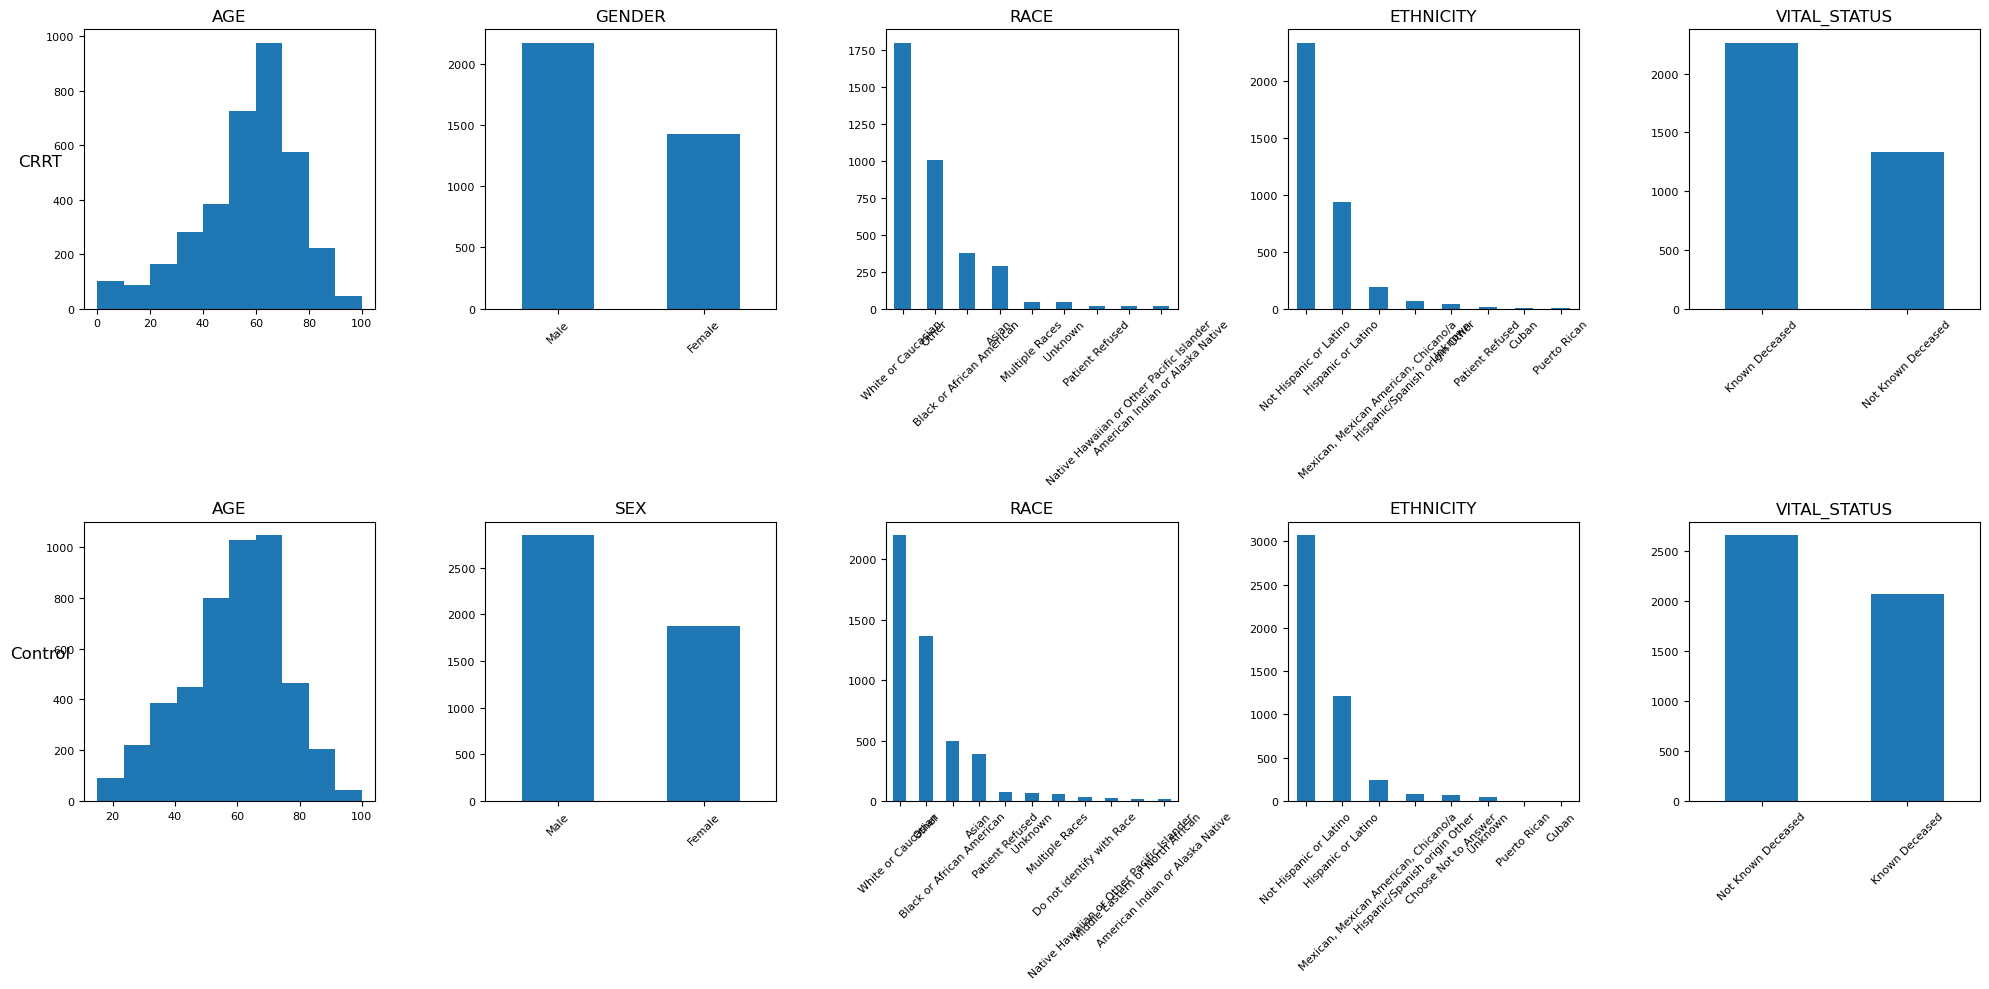

In [106]:
import matplotlib.pyplot as plt

def plot_demo_breakdown(dfs: list[pd.DataFrame], ctn: list[str], drop_cols: list[str], ax: plt.Axes):
    for row, df in enumerate(dfs):
        for i, colname in enumerate(df.drop(drop_cols, axis=1).columns):
            if colname not in ctn:
                data = df[colname].value_counts()
                data.plot.bar(ax=ax[row, i], title=colname, rot=45, layout="tight")
            else:
                data = df[colname]
                data.plot.hist(ax=ax[row, i], title=colname)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
plot_demo_breakdown(
    [
        crrt_df,
        ctrl_df.rename({"IP_CURRENT_PCP_ID": "PCP_IP_PROVIDER_ID"}, axis=1)
    ],
    ["AGE"],
    ["IP_PATIENT_ID", "PCP_IP_PROVIDER_ID"],
    axs
)
for ax, row in zip(axs[:,0], ["CRRT", "Control"]):
    ax.set_ylabel(row, rotation=0, size="large")
fig.tight_layout()
fig.show()

In [114]:
def differences(col: str):
    return set(crrt_df[col].value_counts().index).symmetric_difference(set(ctrl_df[col].value_counts().index))

In [115]:
print(differences("RACE"))
print(differences("ETHNICITY"))

{'Do not identify with Race', 'Middle Eastern or North African'}
{'Choose Not to Answer', 'Patient Refused'}


# Vitals
The vital sign names seems to be mismatching between the crrt patients and controls at UCLA.

Controls have `WEIGHT/SCALE` which is messing with splitting `SBP/DBP`.

In [116]:
vitals = "Flowsheet_Vitals.txt"
crrt_df = read_files_and_combine([vitals], args.ucla_crrt_data_dir)
ctrl_df = read_files_and_combine([vitals], args.ucla_control_data_dir)

unique["vitals"] = {
    "crrt": crrt_df["IP_PATIENT_ID"].nunique(),
    "ctrl": ctrl_df["IP_PATIENT_ID"].nunique()
}
print(unique)

{'vitals': {'crrt': 1082, 'ctrl': 4232}}


In [118]:
crrt_df["VITAL_SIGN_TYPE"].unique()

array(['SpO2', 'O2 Device', 'Temp', 'Height', 'BMI (Calculated)',
       'Weight', 'Resp', 'BP', 'Pulse'], dtype=object)

In [117]:
ctrl_df["VITAL_SIGN_TYPE"].unique()

array(['PULSE', 'RESPIRATIONS', 'PULSE OXIMETRY', 'TEMPERATURE',
       'BLOOD PRESSURE', 'R BMI', 'WEIGHT/SCALE', 'HEIGHT'], dtype=object)

They all map except for O2 Device, which CRRT people have while controls do not.

In [49]:
crrt_df[crrt_df["VITAL_SIGN_TYPE"] == "SpO2"]["VITAL_SIGN_VALUE"]

0        97
4        87
12       98
13       98
14       98
         ..
36517    98
36520    99
36522    98
36525    99
36530    99
Name: VITAL_SIGN_VALUE, Length: 4128, dtype: object

In [51]:
ctrl_df[ctrl_df["vital_sign_type"] == "PULSE OXIMETRY"]["vital_sign_value"]

18            96
19            96
32           100
33           100
38            98
            ... 
121784279    100
121784285    100
121784290    100
121784293    100
121784295    100
Name: vital_sign_value, Length: 29890094, dtype: object

In [53]:
crrt_df[crrt_df["VITAL_SIGN_TYPE"] == "O2 Device"]["VITAL_SIGN_VALUE"]

1                             Bi-PAP
29             Mechanical Ventilator
43                            Bi-PAP
46             None (Room air);Trach
57       Trach;Mechanical Ventilator
                    ...             
36498                None (Room air)
36507      ETT;Mechanical Ventilator
36508                None (Room air)
36519    Trach;Mechanical Ventilator
36533      ETT;Mechanical Ventilator
Name: VITAL_SIGN_VALUE, Length: 4115, dtype: object

# Diagnoses

In [124]:
pt = "1E6D759D88A19B0CFFE1F2EF2B4238CD"
fname = "Encounter_Diagnoses.txt"
crrt_df = read_files_and_combine([fname], args.ucla_crrt_data_dir)
ctrl_df = read_files_and_combine([fname], args.ucla_control_data_dir)

In [125]:
unique["diagnoses"] = {
    "crrt": crrt_df["IP_PATIENT_ID"].nunique(),
    "ctrl": ctrl_df["IP_PATIENT_ID"].nunique()
}
print(unique)

{'vitals': {'crrt': 1082, 'ctrl': 4232}, 'diagnoses': {'crrt': 3596, 'ctrl': 4728}}


In [10]:
from hcuppy.ccs import CCSEngine
from data.utils import read_files_and_combine
from data.longitudinal_utils import hcuppy_map_code

dx_df = read_files_and_combine([fname], args.ucla_control_data_dir)
print(dx_df.shape)
ce = CCSEngine(mode="dx")
icd10_mask = dx_df["ICD_TYPE"] == 10
exploded_cols = ["dx_CCS_CODE",
            "dx_CCS_DESCRIPTION",
            "dx_CCS_LEVEL1",
            "dx_CCS_LEVEL1_DESCRIPTION",
            "dx_CCS_LEVEL2",
            "dx_CCS_LEVEL2_DESCRIPTION",
        ]
mapped = hcuppy_map_code(
        dx_df,
        code_col="ICD_CODE",
        exploded_cols=exploded_cols,
        hcuppy_converter_function=ce.get_ccs,
    )
print(mapped.shape)
mapped.head()

(2093724, 10)
(2093724, 16)


,IP_PATIENT_ID,IP_ENC_ID,DIAGNOSIS_DATE,ICD_TYPE,ICD_CODE,ICD_DESCRIPTION,PRIMARY_DIAGNOSIS_FLAG,ADMISSION_DIAGNOSIS_FLAG,PRESENT_ON_ADMISSION,HOSPITAL_FINAL_DIAGNOSIS,ccs,ccs_desc,ccs_lv1,ccs_lv1_desc,ccs_lv2,ccs_lv2_desc
0,00000064C94859EB973942C862550ABA,2AA979528BA112B797EC4AF75C19C4AB,08/08/2020,10,A41.51,Sepsis due to Escherichia coli (e. coli) (HCC/...,P,0,0,1,2,Septicemia (except in labor),1,Infectious and parasitic diseases,1.1,Bacterial infection
1,00000064C94859EB973942C862550ABA,2AA979528BA112B797EC4AF75C19C4AB,08/08/2020,10,A41.9,"Sepsis, unspecified organism (HCC/RAF)",S,1,0,0,2,Septicemia (except in labor),1,Infectious and parasitic diseases,1.1,Bacterial infection
2,00000064C94859EB973942C862550ABA,2AA979528BA112B797EC4AF75C19C4AB,08/08/2020,10,C16.3,Malignant neoplasm of pyloric antrum (HCC/RAF),S,0,1,1,13,Cancer of stomach,2,Neoplasms,2.2,Other gastrointestinal cancer
3,00000064C94859EB973942C862550ABA,2AA979528BA112B797EC4AF75C19C4AB,08/08/2020,10,C16.9,"Malignant neoplasm of stomach, unspecified (HC...",S,0,0,0,13,Cancer of stomach,2,Neoplasms,2.2,Other gastrointestinal cancer
4,00000064C94859EB973942C862550ABA,2AA979528BA112B797EC4AF75C19C4AB,08/08/2020,10,C78.7,Secondary malignant neoplasm of liver and intr...,S,0,1,1,42,Secondary malignancies,2,Neoplasms,2.12,Secondary malignancies [42.]


In [11]:
mapped_dict = dx_df["ICD_CODE"].apply(lambda code: ce.get_ccs(code))
mapped_dict = pd.DataFrame(mapped_dict.tolist())
mapped_dict.columns = exploded_cols
mapped_dict

,dx_CCS_CODE,dx_CCS_DESCRIPTION,dx_CCS_LEVEL1,dx_CCS_LEVEL1_DESCRIPTION,dx_CCS_LEVEL2,dx_CCS_LEVEL2_DESCRIPTION
0,2,Septicemia (except in labor),1,Infectious and parasitic diseases,1.1,Bacterial infection
1,2,Septicemia (except in labor),1,Infectious and parasitic diseases,1.1,Bacterial infection
2,13,Cancer of stomach,2,Neoplasms,2.2,Other gastrointestinal cancer
3,13,Cancer of stomach,2,Neoplasms,2.2,Other gastrointestinal cancer
4,42,Secondary malignancies,2,Neoplasms,2.12,Secondary malignancies [42.]
...,...,...,...,...,...,...
2093719,na,na,NaN,NaN,NaN,NaN
2093720,na,na,NaN,NaN,NaN,NaN
2093721,na,na,NaN,NaN,NaN,NaN
2093722,na,na,NaN,NaN,NaN,NaN


In [12]:
pd.concat([dx_df, mapped_dict], axis=1)

,IP_PATIENT_ID,IP_ENC_ID,DIAGNOSIS_DATE,ICD_TYPE,ICD_CODE,ICD_DESCRIPTION,PRIMARY_DIAGNOSIS_FLAG,ADMISSION_DIAGNOSIS_FLAG,PRESENT_ON_ADMISSION,HOSPITAL_FINAL_DIAGNOSIS,dx_CCS_CODE,dx_CCS_DESCRIPTION,dx_CCS_LEVEL1,dx_CCS_LEVEL1_DESCRIPTION,dx_CCS_LEVEL2,dx_CCS_LEVEL2_DESCRIPTION
0,00000064C94859EB973942C862550ABA,2AA979528BA112B797EC4AF75C19C4AB,08/08/2020,10,A41.51,Sepsis due to Escherichia coli (e. coli) (HCC/...,P,0,0,1,2,Septicemia (except in labor),1,Infectious and parasitic diseases,1.1,Bacterial infection
1,00000064C94859EB973942C862550ABA,2AA979528BA112B797EC4AF75C19C4AB,08/08/2020,10,A41.9,"Sepsis, unspecified organism (HCC/RAF)",S,1,0,0,2,Septicemia (except in labor),1,Infectious and parasitic diseases,1.1,Bacterial infection
2,00000064C94859EB973942C862550ABA,2AA979528BA112B797EC4AF75C19C4AB,08/08/2020,10,C16.3,Malignant neoplasm of pyloric antrum (HCC/RAF),S,0,1,1,13,Cancer of stomach,2,Neoplasms,2.2,Other gastrointestinal cancer
3,00000064C94859EB973942C862550ABA,2AA979528BA112B797EC4AF75C19C4AB,08/08/2020,10,C16.9,"Malignant neoplasm of stomach, unspecified (HC...",S,0,0,0,13,Cancer of stomach,2,Neoplasms,2.2,Other gastrointestinal cancer
4,00000064C94859EB973942C862550ABA,2AA979528BA112B797EC4AF75C19C4AB,08/08/2020,10,C78.7,Secondary malignant neoplasm of liver and intr...,S,0,1,1,42,Secondary malignancies,2,Neoplasms,2.12,Secondary malignancies [42.]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093719,FFA9E015C8296AA2696A4BA7D0E7D55F,FD62E47F43E23ECC8CF7A9D2813D242B,09/23/2010,9,575.11,Chronic cholecystitis,NaN,0,0,0,na,na,NaN,NaN,NaN,NaN
2093720,FFA9E015C8296AA2696A4BA7D0E7D55F,FD62E47F43E23ECC8CF7A9D2813D242B,09/23/2010,9,586,"Renal failure, unspecified",NaN,0,0,0,na,na,NaN,NaN,NaN,NaN
2093721,FFA9E015C8296AA2696A4BA7D0E7D55F,FD62E47F43E23ECC8CF7A9D2813D242B,09/23/2010,9,V15.82,"Personal history of tobacco use, presenting ha...",NaN,0,0,0,na,na,NaN,NaN,NaN,NaN
2093722,FFA9E015C8296AA2696A4BA7D0E7D55F,FD62E47F43E23ECC8CF7A9D2813D242B,09/23/2010,9,V45.02,Automatic implantable cardiac defibrillator in...,NaN,0,0,0,na,na,NaN,NaN,NaN,NaN


# Labs

In [2]:
labs = "Labs.txt"
crrt_df = read_files_and_combine([labs], args.ucla_crrt_data_dir)
ctrl_df = read_files_and_combine([labs], args.ucla_control_data_dir)

unique["labs"] = {
    "crrt": crrt_df["IP_PATIENT_ID"].nunique(),
    "ctrl": ctrl_df["IP_PATIENT_ID"].nunique()
}
print(unique)

mealy | WARNING - Unexpected encoding in Labs.txt. Encoding with cp1252.


{'labs': {'crrt': 3557, 'ctrl': 4685}}


In [3]:
crrt_df["COMPONENT_NAME"].unique()

array(['SPECIMEN SITE', 'INR', 'CMV IGG', ..., 'P19 I/II',
       'BLUE MUSSEL (F37) IGE BPC', 'P E INTERPRETATION, S(LBC)'],
      dtype=object)

In [4]:
ctrl_df["COMPONENT_NAME"].unique()

array(['OSMOLALITY,URINE', 'WHITE BLOOD CELL COUNT',
       'RED BLOOD CELL COUNT', ..., 'PCO2,TEMP CORRECTED, VENOUS',
       'PO2,TEMP CORRECTED, VENOUS', 'I:E RATIO'], dtype=object)

In [4]:
crrt_set = set(crrt_df["COMPONENT_NAME"].unique())
ctrl_set = set(ctrl_df["COMPONENT_NAME"].unique())
same = crrt_set.intersection(ctrl_set)
print(len(same))
same

4365


{'SIDEROCYTES',
 'COXSACKIE B AB TYPE 2,CSF',
 'MICA ANTIBODY RESULT',
 'DQ7',
 'LYME DISEASE 41 KD IGG',
 'UREA NITROGEN,TIMED URINE',
 'PREGABALIN DOSE',
 'RAGWEED, COMMON (W1) IGE BPC',
 'B27',
 'SERUM PROCESSING',
 'HEMOSIDERIN, URINE',
 'IGF BINDING PROTEIN-1',
 'MICA LOCI 1',
 'A*34:02',
 'WESTERN EQUINE IGG',
 'ALK PHOS PLACENTAL ISOENZYME',
 'PROLYMPHOCYTE',
 'ANTI-AMPHIPHYSIN METHODS',
 'POCT BUPRENORPHINE, UR(MAN)',
 'NON-HDL,CHOLESTEROL,CALC (OSL)',
 'DQA1*03:02',
 'ARSENIC, METHYLATED',
 'M. PNEUMONIAE AB, IGG',
 'LIPID PANEL',
 'EASTERN EQUINE IGG',
 'FATS, NEUTRAL(LBC)',
 'TIMOTHY (G6) IGE BPC',
 'COLOR BF(QST)',
 'MTHFR MUTATION: C.665C>T',
 'ACTH',
 'POCT GLUCOSE(MAN)',
 'CK-MM',
 'METANEPHRINE, FREE(QST)',
 'PCO2,ECMO POSTMEMBRANE',
 'TOBRAMYCIN,EXTENDED INTERVAL',
 'ANTIBODY ID CLASS II',
 'DPA1 IR COMMENT',
 'HEPATITIS C ANTIBODY(QST)',
 'ASPERGILLUS FUMIGATUS(QST)',
 'MONOCYTE,FLUID TOTAL',
 'ALPHA-FETOPROTEIN, PLEURAL FL',
 'VBG INSPIRED O2',
 'NOTE(QST)',
 'NOREPI

In [6]:
diff = crrt_set.symmetric_difference(ctrl_set)
print(len(diff))
diff

2204


{'RETIC CT-TEST, AUTO',
 'WESTERN RAGWEED IGE RAST',
 'SMA DIAGNOSTIC COMMENT',
 'HBV DNA PCR',
 'EOSINOPHILS, SEROUS',
 'GLUCOSE,2 HOUR GEST3HR100G',
 'CD4+/CD45RA+',
 'TROPONINI (OSL)',
 'APTT,PATIENT',
 'B CELL FLOW MCS CXM PRONASE',
 'HGB SOLUBILITY(LBC)',
 'METHYLCITRIC, URINE',
 'CYSTIC FIBROSIS 5T VARIANT',
 'ALCOHOL,ETHYL (B)',
 'HGB S(LBC)',
 'ISOVALERYLGLYCINE',
 'HYDROXYINDOLEACETIC ACID, 5-, URINE, 24 HR(QST)',
 '% CYTO E:T 6.25',
 'SOURCE (HOAG)',
 'PROTEIN ELECTROPHORESIS,CSF',
 'C COMMENT HR',
 'HLA-C IR LOCI 1',
 'TBG BOUND T4',
 'HOURS POST PRANDIAL',
 'DONOR-->RECIPIENT RELATIONSHIP',
 'PEACH (F95) IGE',
 'FSH-ICMA',
 'OLIVE TREE IGE RAST',
 'BANANA (F92) IGE BPC',
 '3-HYDROXYVALERIC',
 'GLUCOSE,ANES',
 'HCG,BETA SUBUNIT,QNT,SERUM(LBC)',
 'CD4, T-CELL SUBSET',
 'AB CL II PRA COMMENT THYMO DEP',
 'BLOOD,CLINITEC',
 'DRB3 LOCI HR1',
 'POCT COVID-19 ANTIGEN (MAN)',
 'HYALURONIC ACID(QST)',
 'SMNP CO-GM1 IGM',
 'DOPAMINE, 24 HR URINE(QST)',
 'HOMOCYSTINE,CSF',
 'SCL-70 AN

In [26]:
import jellyfish
import itertools

def pairwise_diff(diff: set) -> pd.DataFrame:
    results = {
        combo: jellyfish.levenshtein_distance(*combo) for combo in itertools.permutations(diff, 2)
    }
    distances = pd.DataFrame(results.values(), index=results.keys()).sort_values(0)
    return distances

## In crrt but not control

In [27]:
dists = pairwise_diff(crrt_set - ctrl_set)
dists

0
2-HYDROXYGLUTARIC, URINE                3-HYDROXYGLUTARIC, URINE                  1
LYMPH CHORIOMENINGITIS IGG              LYMPH CHORIOMENINGITIS IGM                1
GP46-I                                  GP46-II                                   1
3-HYDROXYBUTYRIC, URINE                 4-HYDROXYBUTYRIC, URINE                   1
2-HYDROXYISOVALERIC, URINE              3-HYDROXYISOVALERIC, URINE                1
...                                                                              ..
GP46-I                                  SUCCINYLACETONE QUANT URINE, INTERPRET.  38
GP21                                    SUCCINYLACETONE QUANT URINE, INTERPRET.  38
SUCCINYLACETONE QUANT URINE, INTERPRET. P19-I                                    38
                                        GP46-I                                   38
                                        GP21                                     38

[75900 rows x 1 columns]

## In control but not crrt

In [28]:
dists = pairwise_diff(ctrl_set - crrt_set)
dists

,,0
B CELL CYTO CROSSMATCH:DTT,T CELL CYTO CROSSMATCH:DTT,1
HGB A2(LBC),HGB A(LBC),1
B CELL SPECIFICITY,T CELL SPECIFICITY,1
"CD4, T-CELL SUBSET","CD3, T-CELL SUBSET",1
DRB4 LOCI IR2,DRB5 LOCI IR2,1
...,...,...
C26:0,TBII (THYROTROPIN BINDING INHIBIT IMMUNOGLOBULIN)(QST),54
TBII (THYROTROPIN BINDING INHIBIT IMMUNOGLOBULIN)(QST),CV2,54
CW*07:02,TBII (THYROTROPIN BINDING INHIBIT IMMUNOGLOBULIN)(QST),54
A*68:01,TBII (THYROTROPIN BINDING INHIBIT IMMUNOGLOBULIN)(QST),54


# Medications

In [29]:
meds = "Medications.txt"
crrt_df = read_files_and_combine([meds], args.ucla_crrt_data_dir)
ctrl_df = read_files_and_combine([meds], args.ucla_control_data_dir)

unique["meds"] = {
    "crrt": crrt_df["IP_PATIENT_ID"].nunique(),
    "ctrl": ctrl_df["IP_PATIENT_ID"].nunique()
}
print(unique)

Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
mealy | WARNING - Error tokenizing data. C error: Expected 18 fields in line 303739, saw 19

mealy | WARNING - Skipping bad lines...
Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.


{'labs': {'crrt': 3557, 'ctrl': 4685}, 'meds': {'crrt': 3557, 'ctrl': 4225}}


In [7]:
crrt_df["PHARM_SUBCLASS"]

0          Heparins And Heparinoid-Like Agents
1                              Opioid Agonists
2                                          NaN
3                                       Sodium
4                                          NaN
                          ...                 
4286782     Bronchodilators - Anticholinergics
4286783          Imidazole-Related Antifungals
4286784          Imidazole-Related Antifungals
4286785                   Glucocorticosteroids
4286786                           Antitussives
Name: PHARM_SUBCLASS, Length: 4286787, dtype: object

In [8]:
ctrl_df["medispan_subclass_name"]

0                                   NaN
1                                   NaN
2                                   NaN
3                                   NaN
4                                   NaN
                       ...             
9414796                 Opioid Agonists
9414797    Miscellaneous Contrast Media
9414798                   Glycopeptides
9414799      Anaphylaxis Therapy Agents
9414800                Sympathomimetics
Name: medispan_subclass_name, Length: 9414801, dtype: object

In [30]:
crrt_set = set(crrt_df["PHARM_SUBCLASS"].unique())
ctrl_set = set(ctrl_df["MEDISPAN_SUBCLASS_NAME"].unique())

In [40]:
print(len(crrt_set.intersection(ctrl_set)))
diff = crrt_set.symmetric_difference(ctrl_set)
print(len(diff))

520
102


In [48]:
pairwise_diff(ctrl_set - crrt_set).iloc[:30]

0
6 each                     1 each                      1
Bulk Chemicals - E's       Bulk Chemicals - D's        1
Alternative Medicine - V's Alternative Medicine - R's  1
500 each                   540 each                    1
Bulk Chemicals - E's       Bulk Chemicals - G's        1
250 each                   270 each                    1
Bulk Chemicals - E's       Bulk Chemicals - S's        1
                           Bulk Chemicals - A's        1
Bulk Chemicals - A's       Bulk Chemicals - H's        1
                           Bulk Chemicals - D's        1
                           Bulk Chemicals - G's        1
                           Bulk Chemicals - S's        1
                           Bulk Chemicals - E's        1
Alternative Medicine - V's Alternative Medicine - O's  1
540 each                   500 each                    1
270 each                   250 each                    1
6 each                     36 each                     1
Bulk Chemicals - D's       Bulk Chemicals - A's        1
                           Bulk Chemicals - E's        1
Alternative Medicine - R's Alternative Medicine - V's  1
                           Alternative Medicine - O's  1
Bulk Chemicals - H's       Bulk Chemicals - D's        1
Bulk Chemicals - D's       Bulk Chemicals - S's        1
Bulk Chemicals - H's       Bulk Chemicals - G's        1
Bulk Chemicals - E's       Bulk Chemicals - H's        1
Bulk Chemicals - G's       Bulk Chemicals - H's        1
                           Bulk Chemicals - D's        1
1 each                     6 each                      1
Alternative Medicine - O's Alternative Medicine - R's  1
800 each                   900 each                    1

In [46]:
pairwise_diff(crrt_set - ctrl_set)

0
1                                                  10                                                   1
                                                   4                                                    1
7                                                  1                                                    1
11                                                 10                                                   1
6                                                  3                                                    1
...                                                                                                    ..
5                                                  Multiple Vitamins w/ Minerals & Calcium-Folic Acid  50
6                                                  Multiple Vitamins w/ Minerals & Calcium-Folic Acid  50
2                                                  Multiple Vitamins w/ Minerals & Calcium-Folic Acid  50
Multiple Vitamins w/ Minerals & Calcium-Folic Acid 11                                                  50
                                                   10                                                  50

[506 rows x 1 columns]

# Problems

In [49]:
probs = "Problem_Lists.txt"
crrt_df = read_files_and_combine([probs], args.ucla_crrt_data_dir)
ctrl_df = read_files_and_combine([probs], args.ucla_control_data_dir)

unique["probs"] = {
    "crrt": crrt_df["IP_PATIENT_ID"].nunique(),
    "ctrl": ctrl_df["IP_PATIENT_ID"].nunique()
}
print(unique)

mealy | WARNING - Unexpected encoding in Problem_Lists.txt. Encoding with cp1252.
mealy | WARNING - Error tokenizing data. C error: Expected 13 fields in line 3474, saw 19

mealy | WARNING - Skipping bad lines...


{'labs': {'crrt': 3557, 'ctrl': 4685}, 'meds': {'crrt': 3557, 'ctrl': 4225}, 'probs': {'crrt': 3216, 'ctrl': 4163}}


In [52]:
crrt_df.columns

Index(['IP_PATIENT_ID', 'IP_ENCOUNTER_ID', 'ENCOUNTER_DATE', 'PROBLEM_LIST_ID',
       'PROB_DESC', 'NOTED_DATE', 'DATE_OF_ENTRY', 'RESOLVED_DATE',
       'PROBLEM_STATUS', 'PROBLEM_CMT'],
      dtype='object')

# Procedures

In [ ]:
procs = "Procedures.txt"
crrt_df = read_files_and_combine([procs], args.ucla_crrt_data_dir)
ctrl_df = read_files_and_combine([procs], args.ucla_control_data_dir)

unique["procs"] = {
    "crrt": crrt_df["IP_PATIENT_ID"].nunique(),
    "ctrl": ctrl_df["IP_PATIENT_ID"].nunique()
}
print(unique)

## time difference of different explode procedures

In [26]:
sample = crrt_df.sample(10000)
sample["VITAL_SIGN_TYPE"].replace(
        {"BP": "SBP/DBP", "BLOOD PRESSURE": "SBP/DBP"}, inplace=True
    )
explode_cols = ["VITAL_SIGN_VALUE", "VITAL_SIGN_TYPE"]

In [30]:
%%timeit -n 100

(
    sample.set_index(list(sample.columns.difference(explode_cols)))
        .apply(lambda col: col.str.split("/").explode())
        .reset_index()
        .reindex(sample.columns, axis=1)
)

22.5 ms ± 220 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
%%timeit  -n 100
b = (
	sample.apply(
		lambda col: col.str.split("/") 
		if col.name in explode_cols else col
	).explode(explode_cols)
)

14.2 ms ± 60.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
a = (
    sample.set_index(list(sample.columns.difference(explode_cols)))
        .apply(lambda col: col.str.split("/").explode())
        .reset_index()
        .reindex(sample.columns, axis=1)
)
b = (
	sample.apply(
		lambda col: col.str.split("/") 
		if col.name in explode_cols else col
	).explode(explode_cols)
    .reset_index(drop=True)  # reset index to be fair comparison
)
a.equals(b)

True